In [1]:
from __future__ import print_function
import distiller 
import argparse
import numpy as np
import os, collections
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import time 

import models
from matplotlib import pyplot as plt
%matplotlib inline

import matplotlib 
matplotlib.rcParams['pdf.fonttype'] = 42


/home/hguan2/anaconda2/envs/distiller/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def load_checkpoint(checkpoint_path):
    resume = checkpoint_path 
    print("=> loading checkpoint '{}'".format(resume))
    checkpoint = torch.load(resume)
    start_epoch = checkpoint['epoch']
    best_prec1 = checkpoint['best_prec1']
    model.load_state_dict(checkpoint['state_dict'])
    
    print("=> loaded checkpoint '{}' (epoch {}) Prec1: {:f}"
          .format(resume, checkpoint['epoch'], best_prec1))


In [3]:
# before regulated training 
# checkpoint_path = './logs/vgg16/cifar10/model_best.pth.tar'
# after regulated training 
checkpoint_path = './logs/vgg16/cifar10/regulated_training/l2_1.0/model_best.pth.tar'
arch = 'vgg'
depth = 16
dataset = 'cifar10'
model_name = 'vgg16'

model = models.__dict__[arch](dataset=dataset, depth=depth)
load_checkpoint(checkpoint_path)


=> loading checkpoint './logs/vgg16/cifar10/regulated_training/l2_1.0/model_best.pth.tar'
=> loaded checkpoint './logs/vgg16/cifar10/regulated_training/l2_1.0/model_best.pth.tar' (epoch 7) Prec1: 0.939000


In [4]:
# post train quantization 
quantizer = distiller.quantization.PostTrainLinearQuantizer(model)
quantizer.prepare_model()

#weights: 14977728 , #params: 14987722 , percentage: 0.999333
[('[0, 32)', 14843216, 99.10192), ('[32, 64)', 130827, 0.873477), ('[64, 128]', 3685, 0.024603)]


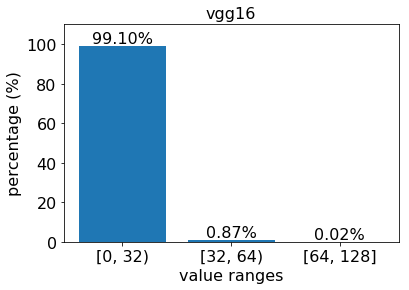

In [5]:
def plot_model_dist(model):
    
    # check the distribution of parameters all weights
    thr = 32
    total_values, num_weights = 0, 0 
    counter = collections.Counter()
    for param_name, param in model.named_parameters():
        total_values += param.nelement()
        if len(param.size()) < 2:
            continue
        num_weights += param.nelement()
        counter.update(collections.Counter(np.abs(param.data.cpu().numpy().ravel())//thr + 1))

    tmp = sorted(counter.items(), key=lambda x: x[0])
    values, counts = zip(*tmp)
    
    # merge the interval [64, 96] and [96, 128]
    values = list(values)[:-1]
    counts = list(counts)
    counts[-2] += counts[-1]
    counts.pop() 

    total_weights = sum(list(counts))
    assert total_weights == num_weights
    print('#weights:', total_weights, ', #params:', total_values, ', percentage:', '%.6f' %(num_weights/total_values))
    
    fontsize = 16
    xticks = ['[0, 32)', '[32, 64)', '[64, 128]']
    percentages = [round(count*100/total_weights, 6) for count in counts]
    print(list(zip(xticks, counts, percentages)))
    
    
    bar = plt.bar(values, percentages)
    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f%%' %(height), ha='center', va='bottom', fontsize = 16)
#     print(['%.6f%%' %(p) for p in percentages])
    #plt.hist(param.data.cpu().numpy().ravel(), bins=10, density=True)
    # plt.xticks(values, [str(int(v)*thr) for v in values])
    plt.xticks(values, xticks, fontsize = 16)
    plt.title(model_name, fontsize = 16)
    #     plt.grid()
    plt.ylim(0, 110)
#     plt.show()
    plt.yticks(fontsize = 16)
    plt.xlabel('value ranges', fontsize = 16)
    plt.ylabel('percentage (%)', fontsize = 16)
    plt.show()
    
plot_model_dist(model)

In [6]:
# count the number of weights that are not in position of 8X but is larger than 64 
def check_large_weights_count():
    count = 0 # number of large weights not in position of 8X 
    total = 0 # total number of weights 
    thr = 64
    for name, param in model.named_parameters():
        if len(param.data.size()) < 2:
            continue 
        tensor1d = param.data.view(-1)
        N = len(tensor1d)
        total += N 
        
        indexes = [i for i in range(N) if i%8 != 0]
        tensor = tensor1d[indexes]
#         total += len(indexes)
        
        large_indexes = torch.nonzero((tensor > thr-1) + (tensor < -thr))
        count += large_indexes.nelement()
    return count, total, count*100/total  

count, total, percentage = check_large_weights_count()
print('#large:%d, total:%d, percentage:%f%%' %(count, total, percentage))


#large:3136, total:14977728, percentage:0.020938%
